# Moons dataset with Decition Tree

_Exercise: train and fine-tune a Decision Tree for the moons dataset._

In [1]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    LearningCurveDisplay,
    ShuffleSplit,
    RandomizedSearchCV,
)
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from scipy.stats import randint, mode

RANDOM_STATE = 42

In [2]:
X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_moons, y_moons, test_size=0.2, random_state=RANDOM_STATE
)

In [4]:
X_train[:5]

array([[-0.56413534,  0.29283681],
       [-1.16033479,  0.96512577],
       [-0.06598769, -0.15191052],
       [-0.38613603,  0.4118307 ],
       [ 0.053037  ,  0.3737536 ]])

In [5]:
y_train[:5]

array([0, 0, 1, 0, 1])

In [6]:
clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf_optimized = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)

In [7]:
randCV = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    {
        "criterion": ["gini", "entropy"],
        "max_depth": randint(1, 20),
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_leaf_nodes": [None, 2, 4, 6, 8, 10]
    },
    scoring="accuracy",
    random_state=RANDOM_STATE,
    cv=3,
)

randCV.fit(X_train, y_train)

clf_optimized = randCV.best_estimator_
randCV.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_leaf_nodes': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

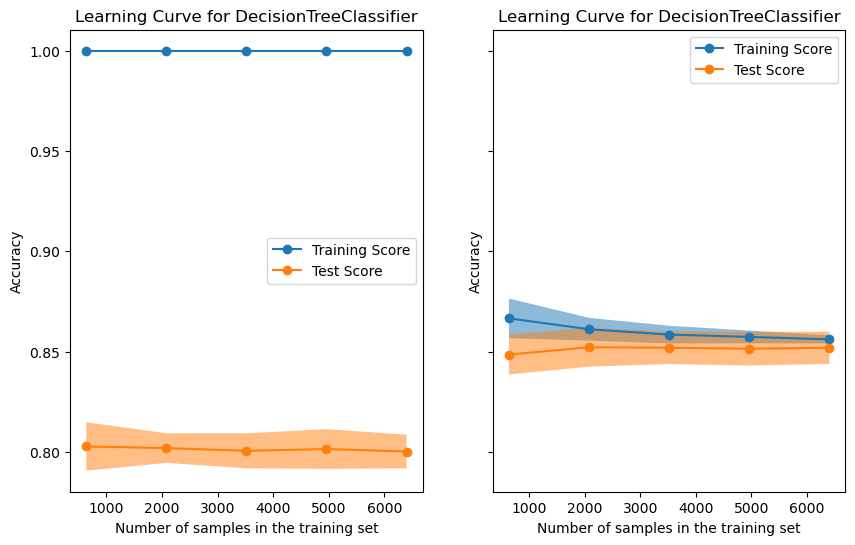

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([clf, clf_optimized]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [9]:
scores = cross_val_score(clf_optimized, X_train, y_train, cv=3, scoring="accuracy")
mean = scores.mean()
mean

0.8525004329447565

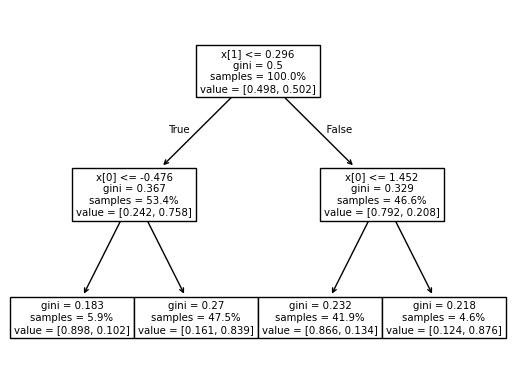

In [10]:
plot_tree(clf_optimized, proportion=True)
plt.show()

In [11]:
clf.fit(X_train, y_train)

predictions = clf_optimized.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1013
           1       0.84      0.89      0.86       987

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



_Exercise: Grow a forest._

a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn's `ShuffleSplit` class for this.

In [12]:
splitter = ShuffleSplit(n_splits=1000, test_size=len(X_train) - 100, random_state=RANDOM_STATE)

b. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [17]:
scores = []
split_clfs = []
for index, (train_index, test_index) in enumerate(splitter.split(X_train)):
    X = X_train[train_index]
    y = y_train[train_index]
    split_clf = DecisionTreeClassifier(**randCV.best_params_)
    split_clf.fit(X, y)
    split_clf_prediction = split_clf.predict(X_test)

    scores.append(accuracy_score(y_test, split_clf_prediction))

    split_clfs.append(split_clf)

np.mean(scores)


0.8347645

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's `mode()` function for this). This gives you _majority-vote predictions_ over the test set.

In [ ]:
predictions = []
for split_clf in split_clfs:
    prediction = split_clf.predict(X = X_test)
    predictions.append(prediction)

predictions_df = pd.DataFrame(predictions)

hard_voting_predictions = []
for index in range(len(X_test)):
    predictions_for_index = predictions_df.iloc[:, index]
    prediction, count = mode(predictions_for_index)
    hard_voting_predictions.append(prediction)

   0     1     2     3     4     5     6     7     8     9     ...  1990  \
0     1     1     0     0     0     1     1     1     1     0  ...     0   
1     1     1     0     0     0     1     1     1     1     0  ...     0   
2     1     1     0     0     0     1     1     1     1     0  ...     0   
3     1     1     0     0     0     1     1     1     1     0  ...     0   
4     1     1     0     0     0     1     1     1     1     0  ...     0   

   1991  1992  1993  1994  1995  1996  1997  1998  1999  
0     1     0     1     1     0     1     0     0     0  
1     0     0     1     1     0     1     0     0     0  
2     0     0     1     1     0     1     0     0     0  
3     0     0     1     1     0     1     0     0     0  
4     0     0     1     1     0     1     0     0     0  

[5 rows x 2000 columns]


d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

In [25]:
hard_voting_predictions[:5]

[1, 1, 0, 0, 0]

In [26]:
score = accuracy_score(y_test, hard_voting_predictions)
score

0.8715